# Notebook 2e : Transformer Multi-tâches + Spike Dropout + Gaussian Noise

## Modifications par rapport au notebook 02

1. **Multi-tâches (position + vitesse)** : le modèle prédit simultanément la position (x, y) et la vitesse de l'animal. La vitesse est une target auxiliaire qui force le modèle à capturer des features plus riches du signal neuronal. Inspiré de [Frey et al. 2021 (eLife)](https://elifesciences.org/articles/66551) qui montrent que le multi-task (position + direction + vitesse) améliore le décodage.

2. **Spike dropout (15%)** : pendant le training, on masque aléatoirement 15% des spikes de chaque séquence. Force le modèle à exploiter des patterns redondants dans la population neuronale.

3. **Gaussian noise sur les waveforms** : pendant le training, on ajoute du bruit N(0, σ²) sur les waveforms bruts. Force le modèle à être robuste au bruit d'enregistrement et empêche la mémorisation de formes de spike exactes.

**Architecture** : identique au notebook 02 (CNN par shank + Transformer + Gaussian NLL), avec une **tête supplémentaire** pour la prédiction de vitesse (MSE loss).

**Loss combinée** : `L = L_position (Gaussian NLL) + λ * L_speed (MSE)` avec λ = 0.5

## 1. Imports et configuration

In [1]:
import pandas as pd
import numpy as np
import json
import os
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

# Reproductibilité
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
print(f'Device: {DEVICE}')

Device: cuda


In [2]:
# --- Chargement des données ---
# Les données doivent être dans data/ (via: python download_data.py)
LOCAL_DIR = os.path.join(os.path.abspath('..'), 'data')

PARQUET_NAME = "M1199_PAG_stride4_win108_test.parquet"
JSON_NAME = "M1199_PAG.json"

PARQUET_FILE = os.path.join(LOCAL_DIR, PARQUET_NAME)
JSON_FILE = os.path.join(LOCAL_DIR, JSON_NAME)

if not os.path.exists(PARQUET_FILE):
    raise FileNotFoundError(
        f"Données introuvables dans {LOCAL_DIR}/\n"
        f"Lancez d'abord: python download_data.py"
    )

print(f"Chargement depuis {LOCAL_DIR}/")
df = pd.read_parquet(PARQUET_FILE)
with open(JSON_FILE, "r") as f:
    params = json.load(f)

print(f"Shape: {df.shape}")

nGroups = params['nGroups']
nChannelsPerGroup = [params[f'group{g}']['nChannels'] for g in range(nGroups)]
print(f"nGroups={nGroups}, nChannelsPerGroup={nChannelsPerGroup}")

Chargement depuis /home/onyxia/work/hacktion-potential/data/
Shape: (62257, 18)
nGroups=4, nChannelsPerGroup=[6, 4, 6, 4]


## 2. Chargement et filtrage

In [3]:
# Filtrage speedMask (on ne garde que les exemples en mouvement)
speed_masks = np.array([x[0] for x in df['speedMask']])
df_moving = df[speed_masks].reset_index(drop=True)
print(f'Exemples en mouvement : {len(df_moving)}')

Exemples en mouvement : 22974


## 3. Preprocessing : reconstruction de la séquence chronologique

Pour chaque fenêtre, on reconstruit la séquence ordonnée de spikes :
1. On reshape les waveforms de chaque shank : `groupX` → `(n_spikes, nCh, 32)`
2. On parcourt le tableau `groups` dans l'ordre chronologique
3. Pour chaque timestep, on récupère le waveform correspondant via `indicesX`
4. On ignore les indices à 0 (padding)

Le résultat : une liste de tuples `(waveform, shank_id)` ordonnée dans le temps.

Comme les shanks ont des nombres de canaux différents (6 ou 4), on utilise un **encodeur par shank** qui projette chaque waveform vers un espace commun de dimension D.

In [4]:
def reconstruct_sequence(row, nGroups, nChannelsPerGroup, max_seq_len=128):
    """
    Reconstruit la séquence chronologique de spikes.
    
    Retourne:
        waveforms_per_group: dict {g: np.array (n_spikes_g, nCh, 32)}
        sequence_groups: np.array (seq_len,) - quel shank à chaque timestep
        sequence_indices: np.array (seq_len,) - quel index de spike dans le shank
        seq_len: longueur effective de la séquence
    """
    groups = row['groups']
    length = min(len(groups), max_seq_len)
    
    # Reshape des waveforms par shank
    waveforms = {}
    for g in range(nGroups):
        nCh = nChannelsPerGroup[g]
        raw = row[f'group{g}']
        waveforms[g] = raw.reshape(-1, nCh, 32)
    
    # Reconstruction de la séquence
    seq_waveforms = []  # liste de (nCh, 32) - taille variable par spike
    seq_shank_ids = []
    
    for t in range(length):
        g = int(groups[t])
        idx = int(row[f'indices{g}'][t])
        if idx > 0 and idx <= waveforms[g].shape[0]:
            seq_waveforms.append((waveforms[g][idx - 1], g))  # idx est 1-based
            seq_shank_ids.append(g)
    
    return seq_waveforms, seq_shank_ids

# Test rapide
wf, sids = reconstruct_sequence(df_moving.iloc[0], nGroups, nChannelsPerGroup)
print(f'Premier exemple : {len(wf)} spikes réels dans la séquence')
print(f'Shanks utilisés : {set(sids)}')
print(f'Premier spike : shank={wf[0][1]}, shape={wf[0][0].shape}')

Premier exemple : 78 spikes réels dans la séquence
Shanks utilisés : {0, 1, 2, 3}
Premier spike : shank=1, shape=(4, 32)


## 4. Dataset PyTorch

Le Dataset gère :
- La reconstruction de séquence à la volée (pas besoin de stocker tout en mémoire)
- Le padding des waveforms à la taille max de canaux (6) pour pouvoir empiler dans un tenseur
- Le retour du masque de padding pour l'attention

On utilise un `collate_fn` custom pour gérer les séquences de longueur variable.

In [5]:
MAX_SEQ_LEN = 128  # On tronque les séquences trop longues (max observé = 190)
MAX_CHANNELS = max(nChannelsPerGroup)  # 6

class SpikeSequenceDataset(Dataset):
    def __init__(self, dataframe, nGroups, nChannelsPerGroup, max_seq_len=MAX_SEQ_LEN):
        self.df = dataframe
        self.nGroups = nGroups
        self.nChannelsPerGroup = nChannelsPerGroup
        self.max_seq_len = max_seq_len
        
        # Pré-extraire les targets : position (x, y) + vitesse
        self.targets = np.array([[x[0], x[1]] for x in dataframe['pos']], dtype=np.float32)
        self.speeds = np.array([x[3] for x in dataframe['pos']], dtype=np.float32)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        seq, shank_ids = reconstruct_sequence(row, self.nGroups, self.nChannelsPerGroup, self.max_seq_len)
        
        seq_len = len(seq)
        if seq_len == 0:
            # Cas dégénéré : aucun spike valide
            seq_len = 1
            waveforms = np.zeros((1, MAX_CHANNELS, 32), dtype=np.float32)
            shank_ids_arr = np.array([0], dtype=np.int64)
        else:
            # Padder les waveforms à MAX_CHANNELS canaux
            waveforms = np.zeros((seq_len, MAX_CHANNELS, 32), dtype=np.float32)
            shank_ids_arr = np.array(shank_ids, dtype=np.int64)
            for t, (wf, g) in enumerate(seq):
                nCh = wf.shape[0]
                waveforms[t, :nCh, :] = wf
        
        target = self.targets[idx]
        speed = self.speeds[idx]
        return {
            'waveforms': torch.from_numpy(waveforms),      # (seq_len, MAX_CH, 32)
            'shank_ids': torch.from_numpy(shank_ids_arr),   # (seq_len,)
            'seq_len': seq_len,
            'target': torch.from_numpy(target),             # (2,)
            'speed': torch.tensor(speed, dtype=torch.float32)  # scalar
        }


def collate_fn(batch):
    """Collate avec padding dynamique à la longueur max du batch."""
    max_len = max(item['seq_len'] for item in batch)
    batch_size = len(batch)
    
    waveforms = torch.zeros(batch_size, max_len, MAX_CHANNELS, 32)
    shank_ids = torch.zeros(batch_size, max_len, dtype=torch.long)
    mask = torch.ones(batch_size, max_len, dtype=torch.bool)  # True = padding (à ignorer)
    targets = torch.stack([item['target'] for item in batch])
    speeds = torch.stack([item['speed'] for item in batch])
    
    for i, item in enumerate(batch):
        sl = item['seq_len']
        waveforms[i, :sl] = item['waveforms']
        shank_ids[i, :sl] = item['shank_ids']
        mask[i, :sl] = False  # False = pas de padding
    
    return {
        'waveforms': waveforms,
        'shank_ids': shank_ids,
        'mask': mask,
        'targets': targets,
        'speeds': speeds
    }

# Vérifier les statistiques de vitesse
speeds_all = np.array([x[3] for x in df_moving['pos']])
print(f'Dataset et collate_fn définis (avec vitesse).')
print(f'Statistiques vitesse : min={speeds_all.min():.4f}, max={speeds_all.max():.4f}, mean={speeds_all.mean():.4f}, std={speeds_all.std():.4f}')

Dataset et collate_fn définis (avec vitesse).
Statistiques vitesse : min=0.0000, max=0.1776, mean=0.0834, std=0.0376


## 5. Architecture du modèle

Identique au notebook 02, avec trois additions :

1. **Spike dropout** dans le `forward()` : masquage aléatoire de 15% des spikes actifs pendant le training.

2. **Gaussian noise** sur les waveforms : ajout de bruit N(0, σ²) sur les waveforms avant l'encodage CNN, pendant le training uniquement.

3. **Tête de prédiction de vitesse** (`speed_head`) : en plus des têtes mu et log_sigma pour la position, une tête MLP supplémentaire prédit la vitesse scalaire de l'animal. Cette tête partage le même backbone Transformer (shared representation learning).

In [6]:
class SpikeEncoder(nn.Module):
    """Encode un waveform (MAX_CH, 32) en un vecteur de dimension embed_dim.
    Utilise un CNN 1D sur la dimension temporelle (32 points)."""
    
    def __init__(self, n_channels, embed_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(n_channels, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, embed_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  # (batch, embed_dim, 1)
        )
    
    def forward(self, x):
        # x: (batch * seq_len, n_channels, 32)
        return self.conv(x).squeeze(-1)  # (batch * seq_len, embed_dim)


class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding."""
    
    def __init__(self, embed_dim, max_len=256):
        super().__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, embed_dim)
    
    def forward(self, x):
        # x: (batch, seq_len, embed_dim)
        return x + self.pe[:, :x.size(1)]


class SpikeTransformer(nn.Module):
    def __init__(self, nGroups, nChannelsPerGroup, embed_dim=64, nhead=4, 
                 num_layers=2, dropout=0.2, spike_dropout=0.15, noise_std=0.5,
                 max_channels=MAX_CHANNELS):
        super().__init__()
        self.nGroups = nGroups
        self.embed_dim = embed_dim
        self.max_channels = max_channels
        self.spike_dropout = spike_dropout
        self.noise_std = noise_std
        
        # Un encodeur par shank
        self.spike_encoders = nn.ModuleList([
            SpikeEncoder(max_channels, embed_dim) for _ in range(nGroups)
        ])
        
        # Embedding de shank
        self.shank_embedding = nn.Embedding(nGroups, embed_dim)
        
        # Positional encoding
        self.pos_encoding = PositionalEncoding(embed_dim)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=nhead, dim_feedforward=embed_dim * 4,
            dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers, enable_nested_tensor=False
        )
        
        # Readout position : mu (2) et log_sigma (2)
        self.mu_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, 2)  # (mu_x, mu_y)
        )
        self.log_sigma_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, 2)  # (log_sigma_x, log_sigma_y)
        )
        
        # Readout vitesse (tâche auxiliaire)
        self.speed_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, 1)  # vitesse scalaire
        )
    
    def _apply_spike_dropout(self, mask):
        """Masque aléatoirement des spikes actifs pendant le training."""
        if not self.training or self.spike_dropout <= 0:
            return mask
        
        drop_mask = torch.rand_like(mask.float()) < self.spike_dropout
        active = ~mask
        new_drops = drop_mask & active
        
        # S'assurer qu'il reste au moins 1 spike par séquence
        remaining = active & ~new_drops
        n_remaining = remaining.sum(dim=1)
        all_dropped = n_remaining == 0
        if all_dropped.any():
            new_drops[all_dropped] = False
        
        return mask | new_drops
    
    def _apply_waveform_noise(self, waveforms):
        """Ajoute du bruit gaussien sur les waveforms pendant le training."""
        if not self.training or self.noise_std <= 0:
            return waveforms
        noise = torch.randn_like(waveforms) * self.noise_std
        return waveforms + noise
    
    def forward(self, waveforms, shank_ids, mask):
        """
        Args:
            waveforms: (batch, seq_len, max_ch, 32)
            shank_ids: (batch, seq_len)
            mask: (batch, seq_len) - True = padding
        Returns:
            mu: (batch, 2) - position prédite
            sigma: (batch, 2) - incertitude (écart-type)
            speed_pred: (batch, 1) - vitesse prédite
        """
        batch_size, seq_len = waveforms.shape[:2]
        
        # --- Data augmentation (training only) ---
        mask = self._apply_spike_dropout(mask)
        waveforms = self._apply_waveform_noise(waveforms)
        
        # --- Encode chaque spike avec l'encodeur de son shank ---
        embeddings = torch.zeros(batch_size, seq_len, self.embed_dim, device=waveforms.device)
        
        for g in range(self.nGroups):
            group_mask = (shank_ids == g) & (~mask)
            if group_mask.any():
                group_wf = waveforms[group_mask]
                group_emb = self.spike_encoders[g](group_wf)
                embeddings[group_mask] = group_emb
        
        # --- Ajouter le shank embedding ---
        shank_emb = self.shank_embedding(shank_ids)
        embeddings = embeddings + shank_emb
        
        # --- Positional encoding ---
        embeddings = self.pos_encoding(embeddings)
        
        # --- Transformer ---
        encoded = self.transformer(embeddings, src_key_padding_mask=mask)
        
        # --- Masked average pooling ---
        active_mask = (~mask).unsqueeze(-1).float()
        pooled = (encoded * active_mask).sum(dim=1) / (active_mask.sum(dim=1) + 1e-8)
        
        # --- Sorties : mu, sigma (position) et speed ---
        mu = self.mu_head(pooled)
        log_sigma = self.log_sigma_head(pooled)
        sigma = torch.exp(log_sigma)  # sigma > 0
        speed_pred = self.speed_head(pooled)  # (batch, 1)
        
        return mu, sigma, speed_pred


# Test rapide
SPIKE_DROPOUT = 0.15
NOISE_STD = 0.5
model = SpikeTransformer(nGroups, nChannelsPerGroup, embed_dim=64, nhead=4, num_layers=2,
                         spike_dropout=SPIKE_DROPOUT, noise_std=NOISE_STD)
n_params = sum(p.numel() for p in model.parameters())
print(f'Modèle créé : {n_params:,} paramètres')
print(f'Data augmentation : spike dropout={SPIKE_DROPOUT:.0%}, gaussian noise std={NOISE_STD}')
print(f'Têtes de sortie : position (mu + sigma) + vitesse')
print(model)

Modèle créé : 141,829 paramètres
Data augmentation : spike dropout=15%, gaussian noise std=0.5
Têtes de sortie : position (mu + sigma) + vitesse
SpikeTransformer(
  (spike_encoders): ModuleList(
    (0-3): 4 x SpikeEncoder(
      (conv): Sequential(
        (0): Conv1d(6, 32, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): ReLU()
        (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
        (4): AdaptiveAvgPool1d(output_size=1)
      )
    )
  )
  (shank_embedding): Embedding(4, 64)
  (pos_encoding): PositionalEncoding()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_fea

## 6. Split et DataLoaders

On sépare les données en **90% train / 10% test** (split temporel : les 10% les plus récents servent de test).

Sur les 90% de train, on effectue une **validation croisée à 5 folds** (KFold, random seed 41) pour :
- Estimer la performance de manière robuste
- Entraîner 5 modèles qui seront ensuite utilisés en ensemble sur le test set

In [7]:
from sklearn.model_selection import KFold

# Split temporel 90/10
split_idx = int(len(df_moving) * 0.9)
df_train_full = df_moving.iloc[:split_idx].reset_index(drop=True)
df_test = df_moving.iloc[split_idx:].reset_index(drop=True)

print(f'Train (full) : {len(df_train_full)} exemples')
print(f'Test         : {len(df_test)} exemples')

# KFold sur les 90% de train
N_FOLDS = 2
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=41)

BATCH_SIZE = 64

# Préparer le test loader (commun à tous les folds)
test_dataset = SpikeSequenceDataset(df_test, nGroups, nChannelsPerGroup)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         collate_fn=collate_fn, num_workers=0)

# Afficher la répartition des folds
for fold, (train_idx, val_idx) in enumerate(kf.split(df_train_full)):
    print(f'  Fold {fold+1}: train={len(train_idx)}, val={len(val_idx)}')

print(f'\nTest: {len(test_dataset)} exemples, {len(test_loader)} batches')

Train (full) : 20676 exemples
Test         : 2298 exemples
  Fold 1: train=10338, val=10338
  Fold 2: train=10338, val=10338

Test: 2298 exemples, 36 batches


## 7. Entraînement (5-Fold Cross-Validation)

Pour chaque fold :
- On entraîne un modèle sur 4/5 des données train, on valide sur le 1/5 restant
- **Loss combinée** : Gaussian NLL (position) + λ × MSE (vitesse)
- **Optimiseur** : AdamW avec weight decay
- **Scheduler** : OneCycleLR (warmup puis decay)
- **Early stopping** basé sur la loss combinée

À la fin, on a 5 modèles qu'on peut ensembler pour le test final.

In [8]:
# Hyperparamètres
EMBED_DIM = 64
NHEAD = 4
NUM_LAYERS = 2
DROPOUT = 0.2
SPIKE_DROPOUT = 0.15  # data augmentation : masquage aléatoire de spikes
NOISE_STD = 0.5       # data augmentation : bruit gaussien sur waveforms
SPEED_WEIGHT = 0.5    # poids de la loss vitesse dans la loss totale
LR = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 30
PATIENCE = 7  # early stopping

print(f'Hyperparamètres : embed_dim={EMBED_DIM}, nhead={NHEAD}, layers={NUM_LAYERS}, dropout={DROPOUT}')
print(f'Data augmentation : spike dropout={SPIKE_DROPOUT:.0%}, gaussian noise std={NOISE_STD}')
print(f'Multi-tâches : speed_weight={SPEED_WEIGHT} (L = L_pos + {SPEED_WEIGHT} * L_speed)')
print(f'Entraînement : {EPOCHS} epochs max, patience={PATIENCE}, LR={LR}')
print(f'Loss : GaussianNLLLoss (position) + MSE (vitesse)')
print(f'Device : {DEVICE}')

Hyperparamètres : embed_dim=64, nhead=4, layers=2, dropout=0.2
Data augmentation : spike dropout=15%, gaussian noise std=0.5
Multi-tâches : speed_weight=0.5 (L = L_pos + 0.5 * L_speed)
Entraînement : 30 epochs max, patience=7, LR=0.001
Loss : GaussianNLLLoss (position) + MSE (vitesse)
Device : cuda


In [9]:
def train_epoch(model, loader, optimizer, scheduler, pos_criterion, speed_criterion, speed_weight, device):
    model.train()
    total_loss = 0
    total_pos_loss = 0
    total_speed_loss = 0
    n_batches = 0
    for batch in loader:
        wf = batch['waveforms'].to(device)
        sid = batch['shank_ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)
        speeds = batch['speeds'].to(device)
        
        optimizer.zero_grad()
        mu, sigma, speed_pred = model(wf, sid, mask)
        
        # Loss position (Gaussian NLL)
        pos_loss = pos_criterion(mu, targets, sigma ** 2)
        # Loss vitesse (MSE)
        speed_loss = speed_criterion(speed_pred.squeeze(-1), speeds)
        # Loss combinée
        loss = pos_loss + speed_weight * speed_loss
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        total_pos_loss += pos_loss.item()
        total_speed_loss += speed_loss.item()
        n_batches += 1
    
    return total_loss / n_batches, total_pos_loss / n_batches, total_speed_loss / n_batches


@torch.no_grad()
def eval_epoch(model, loader, pos_criterion, speed_criterion, speed_weight, device):
    model.eval()
    total_loss = 0
    total_pos_loss = 0
    total_speed_loss = 0
    n_batches = 0
    all_mu = []
    all_sigma = []
    all_targets = []
    all_speed_pred = []
    all_speed_true = []
    for batch in loader:
        wf = batch['waveforms'].to(device)
        sid = batch['shank_ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)
        speeds = batch['speeds'].to(device)
        
        mu, sigma, speed_pred = model(wf, sid, mask)
        
        pos_loss = pos_criterion(mu, targets, sigma ** 2)
        speed_loss = speed_criterion(speed_pred.squeeze(-1), speeds)
        loss = pos_loss + speed_weight * speed_loss
        
        total_loss += loss.item()
        total_pos_loss += pos_loss.item()
        total_speed_loss += speed_loss.item()
        n_batches += 1
        all_mu.append(mu.cpu().numpy())
        all_sigma.append(sigma.cpu().numpy())
        all_targets.append(targets.cpu().numpy())
        all_speed_pred.append(speed_pred.squeeze(-1).cpu().numpy())
        all_speed_true.append(speeds.cpu().numpy())
    
    return (total_loss / n_batches,
            total_pos_loss / n_batches,
            total_speed_loss / n_batches,
            np.concatenate(all_mu), 
            np.concatenate(all_sigma), 
            np.concatenate(all_targets),
            np.concatenate(all_speed_pred),
            np.concatenate(all_speed_true))

In [10]:
# Boucle d'entraînement avec KFold
fold_results = []
all_train_losses = {}
all_val_losses = {}

for fold, (train_idx, val_idx) in enumerate(kf.split(df_train_full)):
    print(f'\n{"="*60}')
    print(f'FOLD {fold+1}/{N_FOLDS}')
    print(f'{"="*60}')
    
    # Créer les datasets pour ce fold
    df_fold_train = df_train_full.iloc[train_idx].reset_index(drop=True)
    df_fold_val = df_train_full.iloc[val_idx].reset_index(drop=True)
    
    fold_train_dataset = SpikeSequenceDataset(df_fold_train, nGroups, nChannelsPerGroup)
    fold_val_dataset = SpikeSequenceDataset(df_fold_val, nGroups, nChannelsPerGroup)
    
    fold_train_loader = DataLoader(fold_train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                   collate_fn=collate_fn, num_workers=0)
    fold_val_loader = DataLoader(fold_val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                 collate_fn=collate_fn, num_workers=0)
    
    print(f'  Train: {len(fold_train_dataset)}, Val: {len(fold_val_dataset)}')
    
    # Nouveau modèle pour chaque fold
    model = SpikeTransformer(
        nGroups, nChannelsPerGroup,
        embed_dim=EMBED_DIM, nhead=NHEAD, num_layers=NUM_LAYERS,
        dropout=DROPOUT, spike_dropout=SPIKE_DROPOUT, noise_std=NOISE_STD
    ).to(DEVICE)
    
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=LR, epochs=EPOCHS, steps_per_epoch=len(fold_train_loader)
    )
    pos_criterion = nn.GaussianNLLLoss()
    speed_criterion = nn.MSELoss()
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    model_path = f'../outputs/best_transformer_02e_fold{fold+1}.pt'
    
    for epoch in range(EPOCHS):
        train_loss, train_pos, train_speed = train_epoch(
            model, fold_train_loader, optimizer, scheduler,
            pos_criterion, speed_criterion, SPEED_WEIGHT, DEVICE
        )
        val_loss, val_pos, val_speed, _, _, _, _, _ = eval_epoch(
            model, fold_val_loader, pos_criterion, speed_criterion, SPEED_WEIGHT, DEVICE
        )
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if epoch % 5 == 0 or epoch == EPOCHS - 1:
            print(f'  Epoch {epoch+1:02d}/{EPOCHS} | Train: {train_loss:.5f} (pos={train_pos:.5f}, spd={train_speed:.5f}) | Val: {val_loss:.5f} (pos={val_pos:.5f}, spd={val_speed:.5f})')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f'  Early stopping a epoch {epoch+1}')
                break
    
    all_train_losses[fold] = train_losses
    all_val_losses[fold] = val_losses
    
    # Évaluer sur la validation de ce fold
    model.load_state_dict(torch.load(model_path, map_location=DEVICE, weights_only=True))
    val_loss, val_pos_loss, val_speed_loss, val_mu, val_sigma, val_targets, val_spd_pred, val_spd_true = eval_epoch(
        model, fold_val_loader, pos_criterion, speed_criterion, SPEED_WEIGHT, DEVICE
    )
    val_eucl = np.sqrt((val_targets[:, 0] - val_mu[:, 0])**2 + (val_targets[:, 1] - val_mu[:, 1])**2)
    val_speed_r2 = r2_score(val_spd_true, val_spd_pred)
    
    fold_results.append({
        'fold': fold + 1,
        'best_val_loss': best_val_loss,
        'val_eucl_mean': val_eucl.mean(),
        'val_r2_x': r2_score(val_targets[:, 0], val_mu[:, 0]),
        'val_r2_y': r2_score(val_targets[:, 1], val_mu[:, 1]),
        'val_speed_r2': val_speed_r2,
        'epochs': len(train_losses),
    })
    print(f'  Best val loss: {best_val_loss:.5f} | Eucl: {val_eucl.mean():.4f} | R2: X={fold_results[-1]["val_r2_x"]:.4f}, Y={fold_results[-1]["val_r2_y"]:.4f} | Speed R2={val_speed_r2:.4f}')

# Résumé des folds
print(f'\n{"="*60}')
print(f'RESUME CROSS-VALIDATION ({N_FOLDS} folds)')
print(f'{"="*60}')
for r in fold_results:
    print(f'  Fold {r["fold"]}: NLL={r["best_val_loss"]:.5f} | Eucl={r["val_eucl_mean"]:.4f} | R2_X={r["val_r2_x"]:.4f} | R2_Y={r["val_r2_y"]:.4f} | Speed_R2={r["val_speed_r2"]:.4f} | Epochs={r["epochs"]}')

mean_eucl = np.mean([r['val_eucl_mean'] for r in fold_results])
std_eucl = np.std([r['val_eucl_mean'] for r in fold_results])
mean_r2_x = np.mean([r['val_r2_x'] for r in fold_results])
mean_r2_y = np.mean([r['val_r2_y'] for r in fold_results])
mean_speed_r2 = np.mean([r['val_speed_r2'] for r in fold_results])
print(f'\n  Moyenne : Eucl={mean_eucl:.4f} (+/- {std_eucl:.4f}) | R2_X={mean_r2_x:.4f} | R2_Y={mean_r2_y:.4f} | Speed_R2={mean_speed_r2:.4f}')


FOLD 1/2
  Train: 10338, Val: 10338
  Epoch 01/30 | Train: -0.42740 (pos=-0.44008, spd=0.02536) | Val: -0.64199 (pos=-0.64294, spd=0.00190)
  Epoch 06/30 | Train: -0.73976 (pos=-0.74065, spd=0.00178) | Val: -0.82942 (pos=-0.83019, spd=0.00155)
  Epoch 11/30 | Train: -0.89730 (pos=-0.89806, spd=0.00152) | Val: -0.95931 (pos=-0.96004, spd=0.00146)
  Epoch 16/30 | Train: -1.02594 (pos=-1.02663, spd=0.00138) | Val: -1.07422 (pos=-1.07493, spd=0.00141)
  Epoch 21/30 | Train: -1.12317 (pos=-1.12384, spd=0.00135) | Val: -1.10822 (pos=-1.10891, spd=0.00138)
  Epoch 26/30 | Train: -1.21726 (pos=-1.21793, spd=0.00133) | Val: -1.13602 (pos=-1.13671, spd=0.00138)
  Epoch 30/30 | Train: -1.24301 (pos=-1.24368, spd=0.00133) | Val: -1.15081 (pos=-1.15150, spd=0.00138)
  Best val loss: -1.17392 | Eucl: 0.2467 | R2: X=0.4647, Y=0.6642 | Speed R2=0.0347

FOLD 2/2
  Train: 10338, Val: 10338
  Epoch 01/30 | Train: -0.20912 (pos=-0.21334, spd=0.00844) | Val: -0.62150 (pos=-0.62223, spd=0.00147)
  Epoch 06

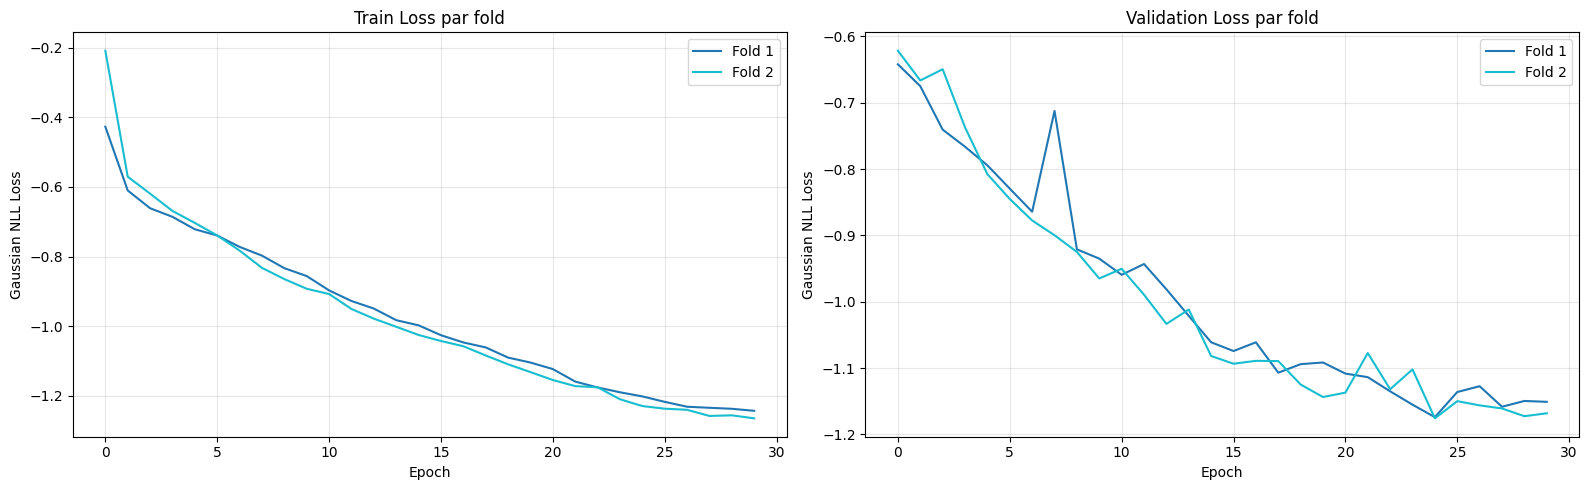

In [11]:
# Courbes d'entraînement par fold
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

colors = plt.cm.tab10(np.linspace(0, 1, N_FOLDS))

for fold in range(N_FOLDS):
    axes[0].plot(all_train_losses[fold], color=colors[fold], linewidth=1.5, label=f'Fold {fold+1}')
    axes[1].plot(all_val_losses[fold], color=colors[fold], linewidth=1.5, label=f'Fold {fold+1}')

axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Gaussian NLL Loss')
axes[0].set_title('Train Loss par fold'); axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Gaussian NLL Loss')
axes[1].set_title('Validation Loss par fold'); axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Évaluation finale sur le test set

On charge les 5 modèles entraînés et on fait la moyenne de leurs prédictions (ensemble). Pour les sigmas, on combine les variances : `sigma_ensemble² = mean(sigma_i²) + mean((mu_i - mu_mean)²)` (loi de la variance totale).

In [12]:
# Évaluation ensemble des N folds sur le test set
pos_criterion = nn.GaussianNLLLoss()
speed_criterion = nn.MSELoss()
all_fold_mu = []
all_fold_sigma = []
all_fold_speed = []

for fold in range(N_FOLDS):
    model_path = f'../outputs/best_transformer_02e_fold{fold+1}.pt'
    model = SpikeTransformer(
        nGroups, nChannelsPerGroup,
        embed_dim=EMBED_DIM, nhead=NHEAD, num_layers=NUM_LAYERS,
        dropout=DROPOUT, spike_dropout=SPIKE_DROPOUT, noise_std=NOISE_STD
    ).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE, weights_only=True))
    
    _, _, _, fold_mu, fold_sigma, y_test, fold_spd_pred, y_speed_test = eval_epoch(
        model, test_loader, pos_criterion, speed_criterion, SPEED_WEIGHT, DEVICE
    )
    all_fold_mu.append(fold_mu)
    all_fold_sigma.append(fold_sigma)
    all_fold_speed.append(fold_spd_pred)
    
    fold_eucl = np.sqrt((y_test[:, 0] - fold_mu[:, 0])**2 + (y_test[:, 1] - fold_mu[:, 1])**2)
    fold_spd_r2 = r2_score(y_speed_test, fold_spd_pred)
    print(f'Fold {fold+1} sur test: Eucl={fold_eucl.mean():.4f}, Speed R2={fold_spd_r2:.4f}')

# Ensemble : moyenne des mu et speed
all_fold_mu = np.stack(all_fold_mu)        # (N_FOLDS, n_test, 2)
all_fold_sigma = np.stack(all_fold_sigma)  # (N_FOLDS, n_test, 2)
all_fold_speed = np.stack(all_fold_speed)  # (N_FOLDS, n_test)

y_pred = all_fold_mu.mean(axis=0)          # (n_test, 2)
y_speed_pred = all_fold_speed.mean(axis=0) # (n_test,)

# Sigma ensemble (loi de la variance totale)
mean_var = (all_fold_sigma ** 2).mean(axis=0)  # aleatoric
var_mu = all_fold_mu.var(axis=0)                # epistemic
y_sigma = np.sqrt(mean_var + var_mu)

# Métriques position
mse_x = mean_squared_error(y_test[:, 0], y_pred[:, 0])
mse_y = mean_squared_error(y_test[:, 1], y_pred[:, 1])
mae_x = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
mae_y = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
r2_x = r2_score(y_test[:, 0], y_pred[:, 0])
r2_y = r2_score(y_test[:, 1], y_pred[:, 1])
eucl_errors = np.sqrt((y_test[:, 0] - y_pred[:, 0])**2 + (y_test[:, 1] - y_pred[:, 1])**2)

# Métriques vitesse
speed_r2 = r2_score(y_speed_test, y_speed_pred)
speed_mse = mean_squared_error(y_speed_test, y_speed_pred)
speed_mae = mean_absolute_error(y_speed_test, y_speed_pred)

print(f'\n=== Transformer 02e : Multi-tâches + Spike Dropout {SPIKE_DROPOUT:.0%} + Noise std={NOISE_STD} — Ensemble ({N_FOLDS} folds) ===')
print(f'\n--- Position ---')
print(f'  MSE  : X={mse_x:.5f}, Y={mse_y:.5f}')
print(f'  MAE  : X={mae_x:.4f}, Y={mae_y:.4f}')
print(f'  R²   : X={r2_x:.4f}, Y={r2_y:.4f}')
print(f'  Eucl : mean={eucl_errors.mean():.4f}, median={np.median(eucl_errors):.4f}, p90={np.percentile(eucl_errors, 90):.4f}')
print(f'\n--- Vitesse ---')
print(f'  R²   : {speed_r2:.4f}')
print(f'  MSE  : {speed_mse:.6f}')
print(f'  MAE  : {speed_mae:.4f}')
print(f'\n--- Incertitude ---')
print(f'  Sigma moyen : X={y_sigma[:, 0].mean():.4f}, Y={y_sigma[:, 1].mean():.4f}')
print(f'  Sigma median: X={np.median(y_sigma[:, 0]):.4f}, Y={np.median(y_sigma[:, 1]):.4f}')

Fold 1 sur test: Eucl=0.2544, Speed R2=0.0253
Fold 2 sur test: Eucl=0.2533, Speed R2=0.0281

=== Transformer 02e : Multi-tâches + Spike Dropout 15% + Noise std=0.5 — Ensemble (2 folds) ===

--- Position ---
  MSE  : X=0.04687, Y=0.04450
  MAE  : X=0.1575, Y=0.1489
  R²   : X=0.4157, Y=0.5790
  Eucl : mean=0.2448, median=0.1995, p90=0.4984

--- Vitesse ---
  R²   : 0.0377
  MSE  : 0.001360
  MAE  : 0.0310

--- Incertitude ---
  Sigma moyen : X=0.1885, Y=0.1662
  Sigma median: X=0.1712, Y=0.1579


## 9. Visualisations

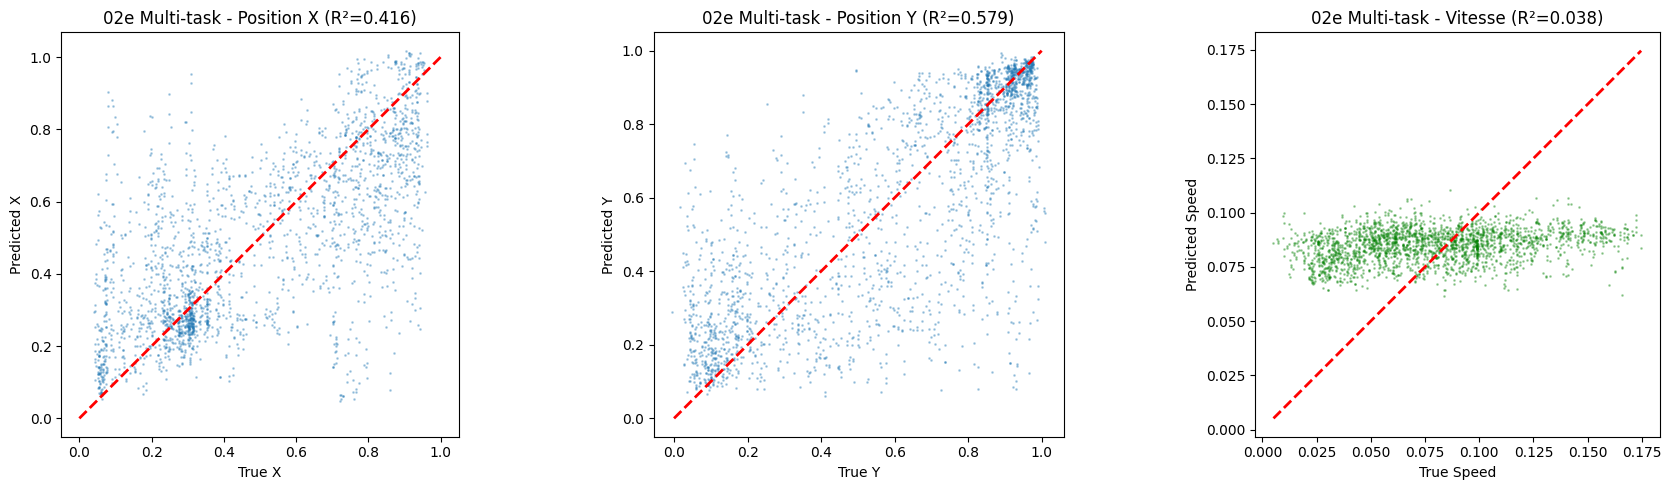

In [13]:
# --- Scatter pred vs true (position + vitesse) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(y_test[:, 0], y_pred[:, 0], s=1, alpha=0.3)
axes[0].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[0].set_xlabel('True X'); axes[0].set_ylabel('Predicted X')
axes[0].set_title(f'02e Multi-task - Position X (R²={r2_x:.3f})')
axes[0].set_aspect('equal')

axes[1].scatter(y_test[:, 1], y_pred[:, 1], s=1, alpha=0.3)
axes[1].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[1].set_xlabel('True Y'); axes[1].set_ylabel('Predicted Y')
axes[1].set_title(f'02e Multi-task - Position Y (R²={r2_y:.3f})')
axes[1].set_aspect('equal')

axes[2].scatter(y_speed_test, y_speed_pred, s=1, alpha=0.3, color='green')
s_min, s_max = y_speed_test.min(), y_speed_test.max()
axes[2].plot([s_min, s_max], [s_min, s_max], 'r--', linewidth=2)
axes[2].set_xlabel('True Speed'); axes[2].set_ylabel('Predicted Speed')
axes[2].set_title(f'02e Multi-task - Vitesse (R²={speed_r2:.3f})')
axes[2].set_aspect('equal')

plt.tight_layout()
plt.show()

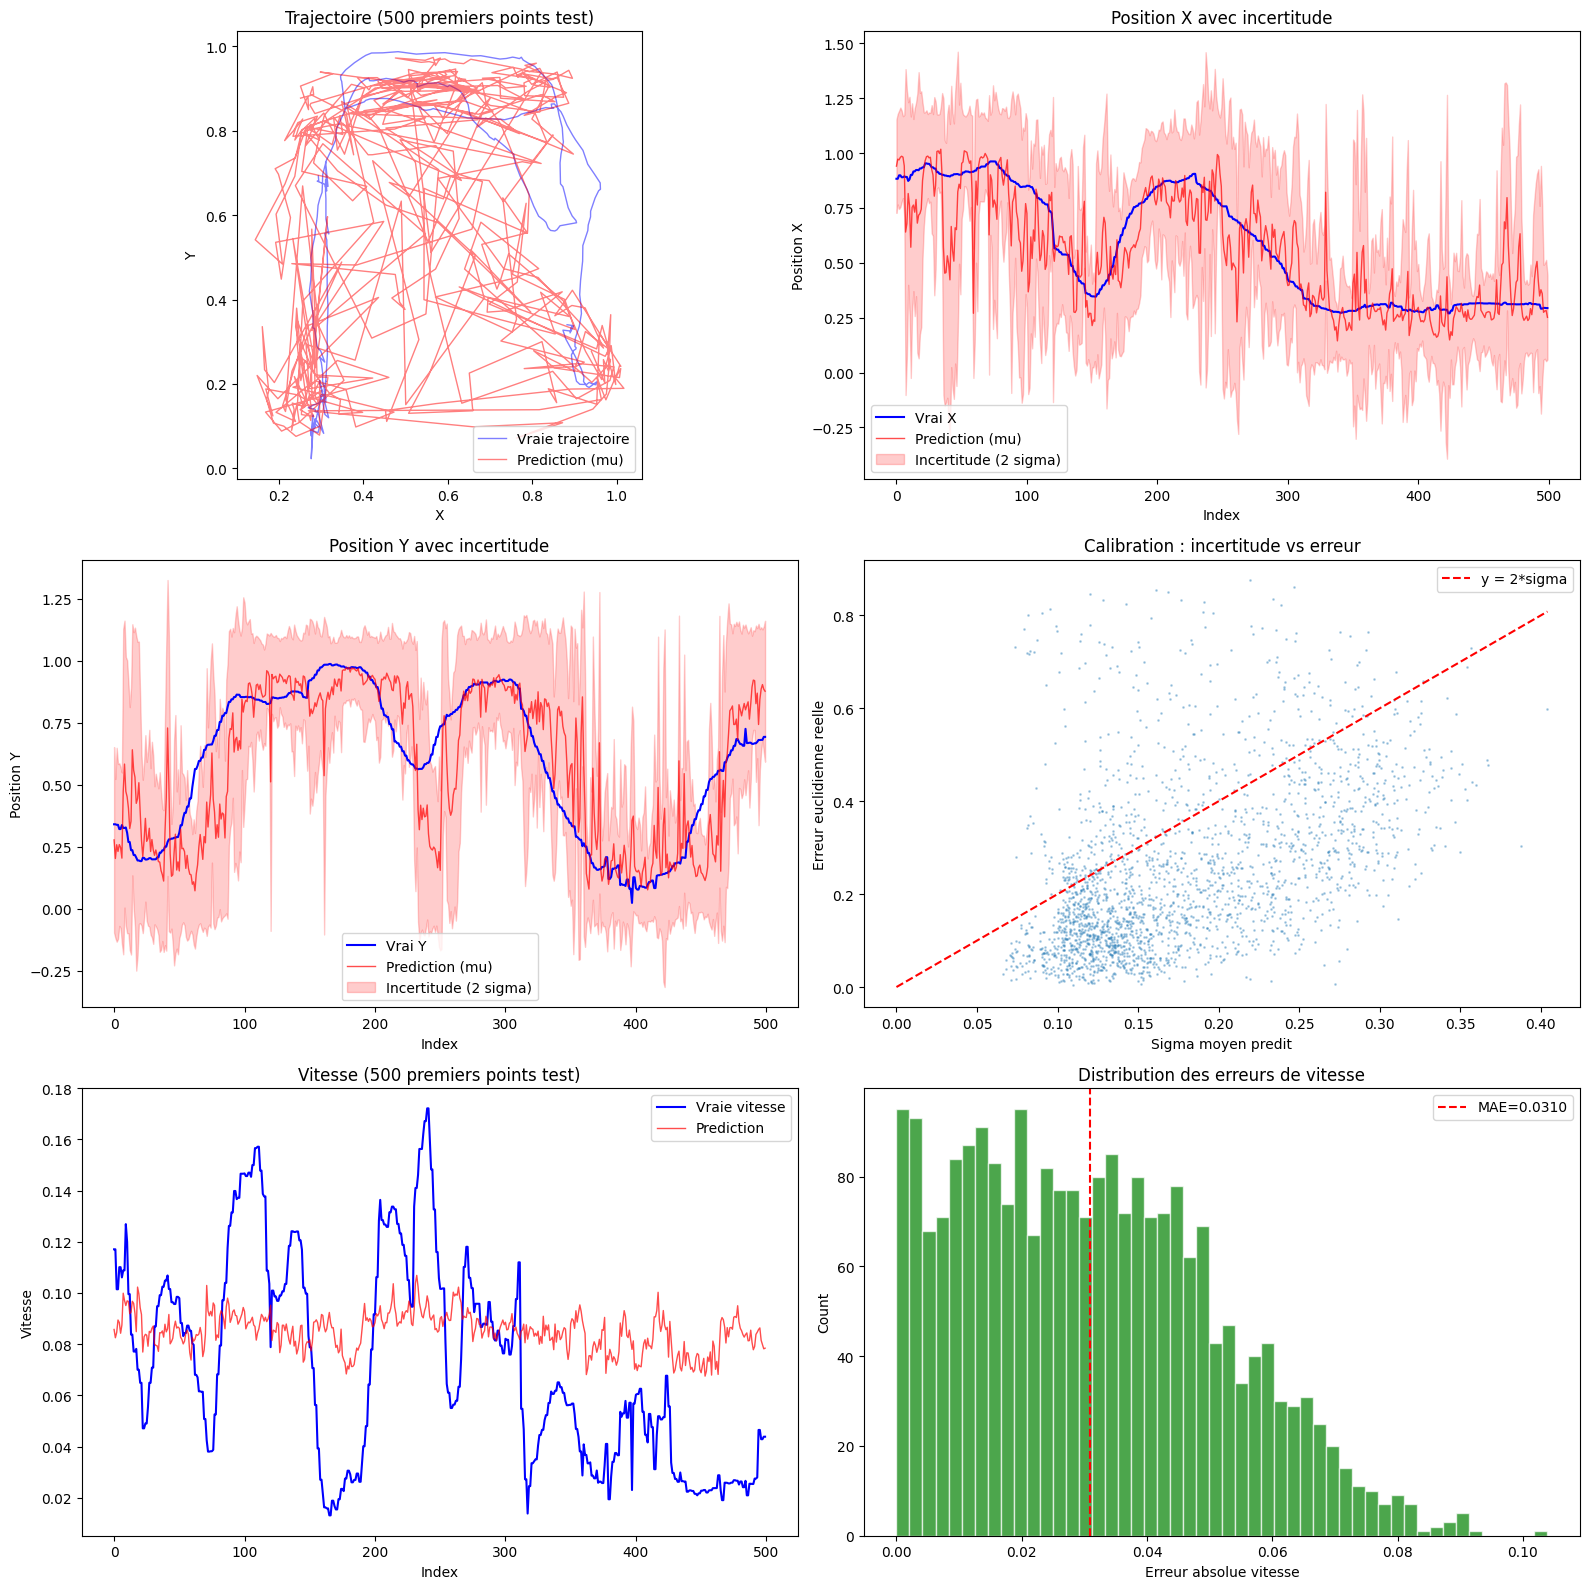

Calibration de l'incertitude :
  Erreur < 1*sigma : 40.6% (attendu ~39% pour gaussienne 2D)
  Erreur < 2*sigma : 81.4% (attendu ~86%)
  Erreur < 3*sigma : 93.8% (attendu ~99%)


In [14]:
# --- Trajectoire prédite vs vraie avec incertitude + vitesse ---
segment = slice(0, 500)
seg_idx = np.arange(500)

fig, axes = plt.subplots(3, 2, figsize=(16, 16))

# 1. Trajectoire 2D
axes[0, 0].plot(y_test[segment, 0], y_test[segment, 1], 'b-', alpha=0.5, label='Vraie trajectoire', linewidth=1)
axes[0, 0].plot(y_pred[segment, 0], y_pred[segment, 1], 'r-', alpha=0.5, label='Prediction (mu)', linewidth=1)
axes[0, 0].set_xlabel('X'); axes[0, 0].set_ylabel('Y')
axes[0, 0].set_title('Trajectoire (500 premiers points test)')
axes[0, 0].legend()
axes[0, 0].set_aspect('equal')

# 2. Position X avec bande d'incertitude (mu +/- 2*sigma)
axes[0, 1].plot(seg_idx, y_test[segment, 0], 'b-', label='Vrai X', linewidth=1.5)
axes[0, 1].plot(seg_idx, y_pred[segment, 0], 'r-', alpha=0.7, label='Prediction (mu)', linewidth=1)
axes[0, 1].fill_between(seg_idx, 
                         y_pred[segment, 0] - 2 * y_sigma[segment, 0],
                         y_pred[segment, 0] + 2 * y_sigma[segment, 0],
                         alpha=0.2, color='red', label='Incertitude (2 sigma)')
axes[0, 1].set_xlabel('Index'); axes[0, 1].set_ylabel('Position X')
axes[0, 1].set_title('Position X avec incertitude')
axes[0, 1].legend()

# 3. Position Y avec bande d'incertitude
axes[1, 0].plot(seg_idx, y_test[segment, 1], 'b-', label='Vrai Y', linewidth=1.5)
axes[1, 0].plot(seg_idx, y_pred[segment, 1], 'r-', alpha=0.7, label='Prediction (mu)', linewidth=1)
axes[1, 0].fill_between(seg_idx,
                         y_pred[segment, 1] - 2 * y_sigma[segment, 1],
                         y_pred[segment, 1] + 2 * y_sigma[segment, 1],
                         alpha=0.2, color='red', label='Incertitude (2 sigma)')
axes[1, 0].set_xlabel('Index'); axes[1, 0].set_ylabel('Position Y')
axes[1, 0].set_title('Position Y avec incertitude')
axes[1, 0].legend()

# 4. Erreur euclidienne vs sigma moyen
sigma_mean = (y_sigma[:, 0] + y_sigma[:, 1]) / 2
axes[1, 1].scatter(sigma_mean, eucl_errors, s=1, alpha=0.3)
axes[1, 1].set_xlabel('Sigma moyen predit'); axes[1, 1].set_ylabel('Erreur euclidienne reelle')
axes[1, 1].set_title('Calibration : incertitude vs erreur')
sigma_range = np.linspace(0, sigma_mean.max(), 100)
axes[1, 1].plot(sigma_range, 2 * sigma_range, 'r--', label='y = 2*sigma', linewidth=1.5)
axes[1, 1].legend()

# 5. Vitesse prédite vs vraie (temporel)
axes[2, 0].plot(seg_idx, y_speed_test[segment], 'b-', label='Vraie vitesse', linewidth=1.5)
axes[2, 0].plot(seg_idx, y_speed_pred[segment], 'r-', alpha=0.7, label='Prediction', linewidth=1)
axes[2, 0].set_xlabel('Index'); axes[2, 0].set_ylabel('Vitesse')
axes[2, 0].set_title('Vitesse (500 premiers points test)')
axes[2, 0].legend()

# 6. Distribution des erreurs de vitesse
speed_errors = np.abs(y_speed_test - y_speed_pred)
axes[2, 1].hist(speed_errors, bins=50, alpha=0.7, color='green', edgecolor='white')
axes[2, 1].axvline(speed_errors.mean(), color='red', linestyle='--', label=f'MAE={speed_errors.mean():.4f}')
axes[2, 1].set_xlabel('Erreur absolue vitesse'); axes[2, 1].set_ylabel('Count')
axes[2, 1].set_title('Distribution des erreurs de vitesse')
axes[2, 1].legend()

plt.tight_layout()
plt.show()

# Calibration : quel % des vraies positions tombe dans l'intervalle predit ?
in_1sigma = np.mean(eucl_errors < sigma_mean)
in_2sigma = np.mean(eucl_errors < 2 * sigma_mean)
in_3sigma = np.mean(eucl_errors < 3 * sigma_mean)
print(f'Calibration de l\'incertitude :')
print(f'  Erreur < 1*sigma : {in_1sigma:.1%} (attendu ~39% pour gaussienne 2D)')
print(f'  Erreur < 2*sigma : {in_2sigma:.1%} (attendu ~86%)')
print(f'  Erreur < 3*sigma : {in_3sigma:.1%} (attendu ~99%)')

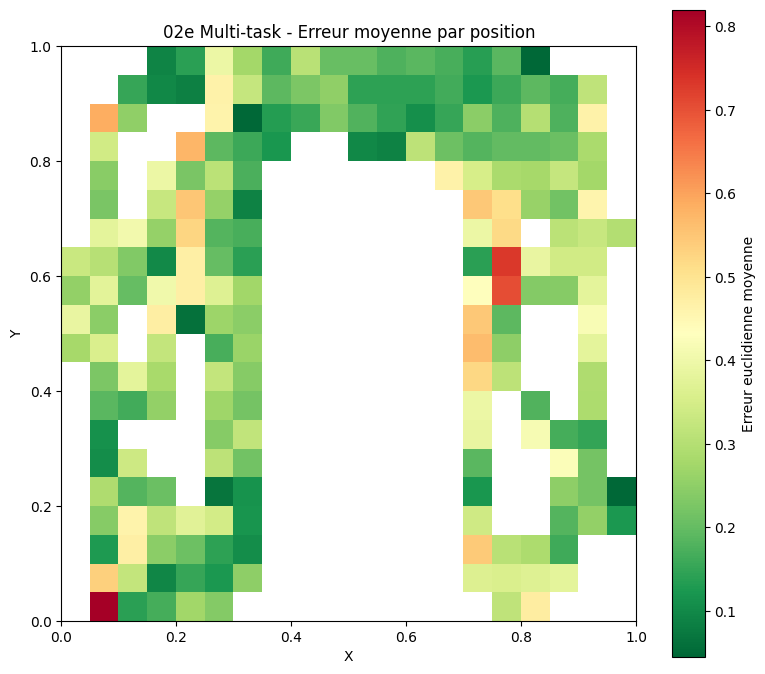

In [15]:
# --- Heatmap des erreurs spatiales ---
fig, ax = plt.subplots(figsize=(8, 7))

nbins = 20
error_map = np.full((nbins, nbins), np.nan)
count_map = np.zeros((nbins, nbins))
x_edges = np.linspace(0, 1, nbins + 1)
y_edges = np.linspace(0, 1, nbins + 1)

for i in range(len(y_test)):
    xi = np.clip(np.searchsorted(x_edges, y_test[i, 0]) - 1, 0, nbins - 1)
    yi = np.clip(np.searchsorted(y_edges, y_test[i, 1]) - 1, 0, nbins - 1)
    if np.isnan(error_map[yi, xi]):
        error_map[yi, xi] = 0
    error_map[yi, xi] += eucl_errors[i]
    count_map[yi, xi] += 1

mean_error_map = np.where(count_map > 0, error_map / count_map, np.nan)

im = ax.imshow(mean_error_map, origin='lower', aspect='equal', cmap='RdYlGn_r', extent=[0, 1, 0, 1])
ax.set_xlabel('X'); ax.set_ylabel('Y')
ax.set_title('02e Multi-task - Erreur moyenne par position')
plt.colorbar(im, ax=ax, label='Erreur euclidienne moyenne')
plt.tight_layout()
plt.show()

## 10. Sauvegarde des prédictions

In [16]:
np.save('../outputs/preds_transformer_02e.npy', y_pred)
np.save('../outputs/sigma_transformer_02e.npy', y_sigma)
np.save('../outputs/y_test_transformer_02e.npy', y_test)
np.save('../outputs/speed_pred_transformer_02e.npy', y_speed_pred)
np.save('../outputs/speed_test_transformer_02e.npy', y_speed_test)
print(f'Predictions ensemble ({N_FOLDS} folds) sauvegardees.')
print(f'  preds_transformer_02e.npy : mu ensemble ({y_pred.shape})')
print(f'  sigma_transformer_02e.npy : sigma ensemble ({y_sigma.shape})')
print(f'  y_test_transformer_02e.npy : targets ({y_test.shape})')
print(f'  speed_pred_transformer_02e.npy : speed predictions ({y_speed_pred.shape})')
print(f'  speed_test_transformer_02e.npy : speed targets ({y_speed_test.shape})')

Predictions ensemble (2 folds) sauvegardees.
  preds_transformer_02e.npy : mu ensemble ((2298, 2))
  sigma_transformer_02e.npy : sigma ensemble ((2298, 2))
  y_test_transformer_02e.npy : targets ((2298, 2))
  speed_pred_transformer_02e.npy : speed predictions ((2298,))
  speed_test_transformer_02e.npy : speed targets ((2298,))


## 11. Analyse de l'incertitude

Avec la sortie probabiliste (Gaussian NLL), le modèle prédit non seulement une position (mu) mais aussi son incertitude (sigma). Cela permet de :
- **Identifier les zones difficiles** : là où sigma est élevé, le modèle "sait qu'il ne sait pas"
- **Pondérer les prédictions** : en aval, on peut donner moins de poids aux prédictions incertaines
- **Détecter les anomalies** : des sigma anormalement élevés peuvent signaler des données hors distribution

Le multi-task learning devrait améliorer la calibration : en apprenant aussi la vitesse, le modèle développe des représentations internes plus riches qui permettent une meilleure estimation de l'incertitude.

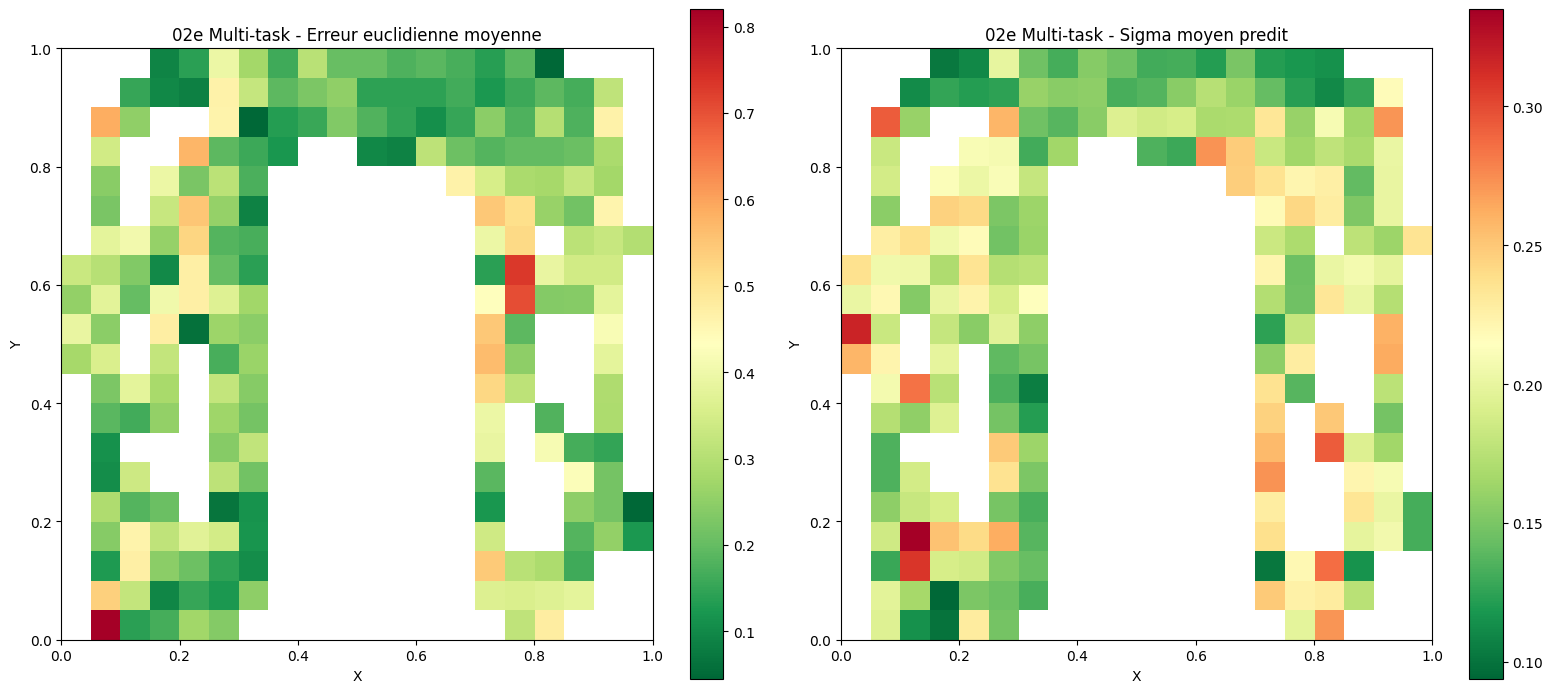

Correlation de Spearman (sigma vs erreur) : 0.518 (p=3.51e-158)
  -> Bonne calibration : le modele sait quand il se trompe


In [17]:
# --- Heatmap de l'incertitude moyenne par position ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

nbins = 20
x_edges = np.linspace(0, 1, nbins + 1)
y_edges = np.linspace(0, 1, nbins + 1)

for ax_idx, (title, values) in enumerate([
    ('Erreur euclidienne moyenne', eucl_errors),
    ('Sigma moyen predit', (y_sigma[:, 0] + y_sigma[:, 1]) / 2)
]):
    val_map = np.full((nbins, nbins), np.nan)
    count_map = np.zeros((nbins, nbins))
    
    for i in range(len(y_test)):
        xi = np.clip(np.searchsorted(x_edges, y_test[i, 0]) - 1, 0, nbins - 1)
        yi = np.clip(np.searchsorted(y_edges, y_test[i, 1]) - 1, 0, nbins - 1)
        if np.isnan(val_map[yi, xi]):
            val_map[yi, xi] = 0
        val_map[yi, xi] += values[i]
        count_map[yi, xi] += 1
    
    mean_map = np.where(count_map > 0, val_map / count_map, np.nan)
    
    im = axes[ax_idx].imshow(mean_map, origin='lower', aspect='equal', 
                              cmap='RdYlGn_r', extent=[0, 1, 0, 1])
    axes[ax_idx].set_xlabel('X'); axes[ax_idx].set_ylabel('Y')
    axes[ax_idx].set_title(f'02e Multi-task - {title}')
    plt.colorbar(im, ax=axes[ax_idx])

plt.tight_layout()
plt.show()

# Correlation entre sigma predit et erreur reelle
from scipy.stats import spearmanr
corr, pval = spearmanr(sigma_mean, eucl_errors)
print(f'Correlation de Spearman (sigma vs erreur) : {corr:.3f} (p={pval:.2e})')
print(f'  -> {"Bonne" if corr > 0.3 else "Faible"} calibration : le modele {"sait" if corr > 0.3 else "ne sait pas bien"} quand il se trompe')

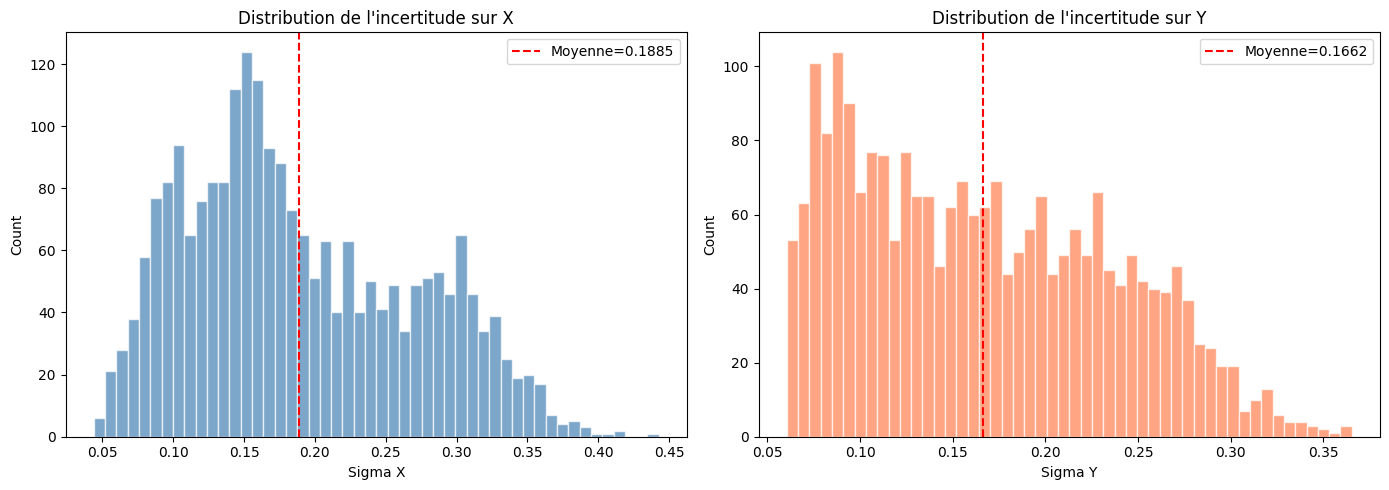

In [18]:
# --- Distribution des sigma predits ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y_sigma[:, 0], bins=50, alpha=0.7, color='steelblue', edgecolor='white')
axes[0].axvline(y_sigma[:, 0].mean(), color='red', linestyle='--', label=f'Moyenne={y_sigma[:, 0].mean():.4f}')
axes[0].set_xlabel('Sigma X'); axes[0].set_ylabel('Count')
axes[0].set_title('Distribution de l\'incertitude sur X')
axes[0].legend()

axes[1].hist(y_sigma[:, 1], bins=50, alpha=0.7, color='coral', edgecolor='white')
axes[1].axvline(y_sigma[:, 1].mean(), color='red', linestyle='--', label=f'Moyenne={y_sigma[:, 1].mean():.4f}')
axes[1].set_xlabel('Sigma Y'); axes[1].set_ylabel('Count')
axes[1].set_title('Distribution de l\'incertitude sur Y')
axes[1].legend()

plt.tight_layout()
plt.show()

## 12. Interpretation

### Modifications apportées (02e vs 02)

**1. Multi-tâches (position + vitesse)** : le modèle prédit simultanément la position (x, y) via Gaussian NLL et la vitesse via MSE. La loss combinée est `L = L_pos + 0.5 * L_speed`. Inspiré de [Frey et al. 2021](https://elifesciences.org/articles/66551) qui montrent que le multi-task (position + direction + vitesse) améliore le décodage spatial hippocampique.

**Pourquoi le multi-task aide :**
- La vitesse est une variable cinématique liée à la position (c'est sa dérivée temporelle)
- Les place cells hippocampiques encodent conjointement position et vitesse
- Forcer le backbone Transformer à extraire des features utiles pour les deux tâches agit comme un **régulariseur inductif** : le modèle doit apprendre des représentations plus riches et moins spécifiques à une seule tâche

**2. Spike dropout (15%)** : masquage aléatoire de spikes actifs pendant le training.

**3. Gaussian noise (std=0.5)** : bruit additif N(0, 0.5²) sur les waveforms bruts pendant le training.

### Résumé des modifications cumulées
| Composant | 02 (baseline) | 02e (ce notebook) |
|-----------|--------------|-------------------|
| Spike dropout | Non | Oui (15%) |
| Gaussian noise | Non | Oui (std=0.5) |
| Multi-tâches | Non | Oui (position + vitesse) |
| Loss | Gaussian NLL | Gaussian NLL + 0.5 * MSE(speed) |
| Nb paramètres | ~200k | ~204k (+speed_head) |